<a href="https://colab.research.google.com/github/MRTAT/Crawl-Gold-and-USD-Price/blob/master/USD_GOLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install selenium
!apt-get update
!apt-get install chromium chromium-driver
!apt-get install -y chromium-browser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,071 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
H

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import json
import pandas as pd
from datetime import datetime, timedelta
from selenium import webdriver

# Hàm để tạo web driver
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')  # Chạy không có giao diện người dùng
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920,1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

In [4]:

# Hàm để lấy dữ liệu tỷ giá USD/VND từ trang Exchange-Rates
def get_exchange_rate_data():
    driver = web_driver()
    url = 'https://www.exchange-rates.org/exchange-rate-history/usd-vnd'
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    rows = soup.select('table.history-rates-data tbody tr')
    data = []

    for row in rows:
        date_cell = row.find('td')
        if date_cell:
            date_span = date_cell.find('span', class_='nowrap')
            if date_span:
                date = date_span.get_text(strip=True)
                price_cell = date_cell.find_next_sibling('td')
                price_text = price_cell.find_all('span', class_='nowrap')[-1].get_text(strip=True)
                price = price_text.strip().replace(' VND', '').replace(',', '')
                data.append((date, price))

    driver.quit()
    df_exchange = pd.DataFrame(data, columns=['Date', 'USD_Price'])
    df_exchange['Date'] = pd.to_datetime(df_exchange['Date'])
    six_months_ago = datetime.now() - timedelta(days=180)
    return df_exchange[df_exchange['Date'] >= six_months_ago]

In [5]:
# Hàm để lấy dữ liệu giá vàng từ Webgia
def get_gold_price_data():
    url = 'https://webgia.com/gia-vang/sjc/bieu-do-6-thang.html'
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Không thể truy cập. Mã trạng thái: {response.status_code}")
        return pd.DataFrame()

    soup = BeautifulSoup(response.content, 'html.parser')
    scripts = soup.find_all('script')
    pattern = re.compile(r'var seriesOptions = (\[.*?\]);', re.DOTALL)
    series_data = None

    for script in scripts:
        if script.string:
            match = pattern.search(script.string)
            if match:
                series_data = match.group(1)
                break

    if not series_data:
        print("Không tìm thấy dữ liệu trong script.")
        return pd.DataFrame()

    try:
        series_data = series_data.replace("'", '"')
        series_data = re.sub(r'(\w+):', r'"\1":', series_data)
        series_json = json.loads(series_data)
    except json.JSONDecodeError as e:
        print(f"Lỗi khi chuyển đổi dữ liệu thành JSON: {e}")
        return pd.DataFrame()

    def process_series(series):
        name = series.get('name', '').lower()
        data = series.get('data', [])
        processed_data = []

        for point in data:
            timestamp_ms, price = point
            date = datetime.fromtimestamp(timestamp_ms / 1000).strftime('%Y-%m-%d')
            processed_data.append({'Date': date, 'Gold_Price': price})
        return name, pd.DataFrame(processed_data)

    for series in series_json:
        name, df_gold = process_series(series)
        if "mua vào" in name:
            df_gold['Date'] = pd.to_datetime(df_gold['Date'])
            six_months_ago = datetime.now() - timedelta(days=180)
            return df_gold[df_gold['Date'] >= six_months_ago]

In [6]:

# Lấy dữ liệu từ cả hai nguồn
df_usd = get_exchange_rate_data()
df_gold = get_gold_price_data()

# Merged with purpose on Draw Chart
merged_df = pd.merge(df_usd, df_gold, on='Date', how='inner')

# Chuẩn hóa dữ liệu:
merged_df['USD_Price'] = merged_df['USD_Price'].astype(float)
merged_df['Gold_Price'] = merged_df['Gold_Price'] * 1e6  # Chuyển sang đơn vị triệu


df = merged_df
df


,Date,USD_Price,Gold_Price
0,2024-10-23,25410.0,87000000.0
1,2024-10-22,25403.0,87000000.0
2,2024-10-21,25304.0,86000000.0
3,2024-10-18,25167.0,84000000.0
4,2024-10-17,25191.0,84000000.0
...,...,...,...
105,2024-05-08,25432.0,85100000.0
106,2024-05-07,25410.0,84600000.0
107,2024-05-06,25377.0,83800000.0
108,2024-05-03,25416.0,82900000.0


# Data analysis

In [13]:
df_gold

,Date,Gold_Price
0,2024-05-02,82.5
1,2024-05-03,82.9
2,2024-05-04,83.5
3,2024-05-06,83.8
4,2024-05-07,84.6
...,...,...
124,2024-10-18,84.0
125,2024-10-19,84.0
126,2024-10-21,86.0
127,2024-10-22,87.0


In [14]:
# This is for Gold_Price, Usd_Price (df_usd) is same thing well.
mean = df_gold['Gold_Price'].mean()
mean


80.09767441860465

In [15]:
df_gold['Gold_Price'].median()

79.0

In [16]:
df_gold['Gold_Price'].min()

74.98

In [17]:
df_gold['Gold_Price'].max()

88.9

In [18]:
std = df_gold['Gold_Price'].std()
std

4.324448395393177

In [19]:
# Variance = Std / mean
var = std / mean
var


0.05398968730094263

In [52]:
df

,Date,USD_Price,Gold_Price
0,2024-10-23,25410.0,87000000.0
1,2024-10-22,25403.0,87000000.0
2,2024-10-21,25304.0,86000000.0
3,2024-10-18,25167.0,84000000.0
4,2024-10-17,25191.0,84000000.0
...,...,...,...
105,2024-05-08,25432.0,85100000.0
106,2024-05-07,25410.0,84600000.0
107,2024-05-06,25377.0,83800000.0
108,2024-05-03,25416.0,82900000.0


In [21]:
# Show the 5 days with the highest gold price
highest = df_gold.sort_values(by='Gold_Price', ascending=False)
highest.head(5)

,Date,Gold_Price
22,2024-05-29,88.9
18,2024-05-23,88.9
17,2024-05-22,88.9
16,2024-05-21,88.8
8,2024-05-11,88.8


In [22]:
# Show the 5 days with the highest Usd price
highest = df_usd.sort_values(by='USD_Price', ascending=False)
highest.head(5)

,Date,USD_Price
110,2024-05-24,25471
111,2024-05-23,25470
87,2024-06-26,25468
112,2024-05-22,25465
113,2024-05-21,25461


In [33]:
#  Calculate the average gold price by month
df_gold['Month'] = df_gold['Date'].dt.month

avg_gold_month = df_gold.groupby('Month')['Gold_Price'].mean()
avg_gold_month

,Gold_Price
Month,
5,86.696000
6,75.900952
7,76.425217
8,78.050000
9,79.664706
10,83.473684


In [43]:
#  Calculate the average Usd price by month
df_usd['Month'] = df_usd['Date'].dt.month
df_usd['USD_Price'] = pd.to_numeric(df_usd['USD_Price'])
avg_usd_month = df_usd.groupby('Month')['USD_Price'].mean().round(2)
avg_usd_month

,USD_Price
Month,
5,25444.77
6,25444.05
7,25376.13
8,25026.50
9,24650.38
10,25001.58


In [41]:
# Show the 2 months with the highest average gold
highest_gold = avg_gold_month.sort_values(ascending=False)
highest_gold.head(2)

,Gold_Price
Month,
5,86.696000
10,83.473684


In [45]:
# Show the 2 months with the highest average dollar
highest_usd = avg_usd_month.sort_values(ascending=False)
highest_usd.head(2)

,USD_Price
Month,
5,25444.77
6,25444.05


In [53]:
gold = avg_gold_month
usd = avg_usd_month
merged_df = pd.merge(gold, usd, on = 'Month').reset_index()
merged_df

,Month,Gold_Price,USD_Price
0,5,86.696000,25444.77
1,6,75.900952,25444.05
2,7,76.425217,25376.13
3,8,78.050000,25026.50
4,9,79.664706,24650.38
5,10,83.473684,25001.58


#  Data Visualization

## Chart 1: Draw a chart showing the average gold price and the average USD price by month.

In [61]:
from sklearn.preprocessing import StandardScaler
import pandas as pd




scaler = StandardScaler()

# Áp dụng scaler lên các cột USD_Price và Gold_Price
scaled_data = scaler.fit_transform(merged_df[['USD_Price', 'Gold_Price']])

# Tạo DataFrame từ dữ liệu đã chuẩn hóa và gán tên cột
scaled_df = pd.DataFrame(scaled_data, columns=['USD_Scaled', 'Gold_Scaled'])

# Kết hợp lại với cột 'Date'
merged_df_scaled = pd.concat([merged_df[['Month']], scaled_df], axis=1)

# Hiển thị DataFrame kết quả
dfs_month = merged_df_scaled
dfs_month

# Input bất kì -> Input chuẩn gaussion distribution
# Range khác nhau

,Month,USD_Scaled,Gold_Scaled
0,5,0.985198,1.716108
1,6,0.982731,-1.065115
2,7,0.750013,-0.930044
3,8,-0.447945,-0.511437
4,9,-1.736667,-0.095426
5,10,-0.533330,0.885915


<function matplotlib.pyplot.show(close=None, block=None)>

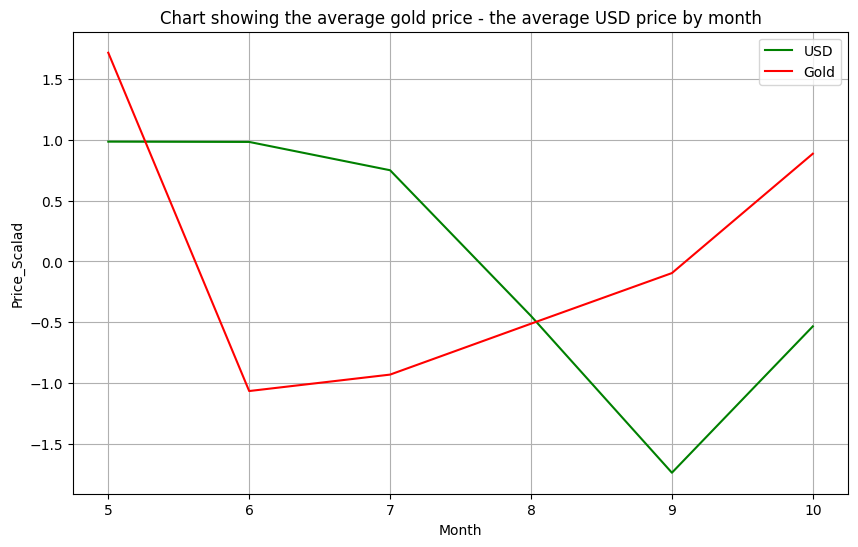

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

plt.plot(dfs_month.Month, dfs_month.USD_Scaled, label='USD', linestyle='-', color='green')
plt.plot(dfs_month.Month, dfs_month.Gold_Scaled, label='Gold', linestyle='-', color='red')

plt.title('Chart showing the average gold price - the average USD price by month')
plt.xlabel('Month')
plt.ylabel('Price_Scalad')

plt.grid(True)
plt.legend()
plt.show

# Chart 2

### Preprocessing Data

In [65]:
df

,Date,USD_Price,Gold_Price
0,2024-10-23,25410.0,87000000.0
1,2024-10-22,25403.0,87000000.0
2,2024-10-21,25304.0,86000000.0
3,2024-10-18,25167.0,84000000.0
4,2024-10-17,25191.0,84000000.0
...,...,...,...
105,2024-05-08,25432.0,85100000.0
106,2024-05-07,25410.0,84600000.0
107,2024-05-06,25377.0,83800000.0
108,2024-05-03,25416.0,82900000.0


In [66]:
from sklearn.preprocessing import StandardScaler
import pandas as pd




scaler = StandardScaler()

# Áp dụng scaler lên các cột USD_Price và Gold_Price
scaled_data = scaler.fit_transform(df[['USD_Price', 'Gold_Price']])

# Tạo DataFrame từ dữ liệu đã chuẩn hóa và gán tên cột
scaled_df = pd.DataFrame(scaled_data, columns=['USD_Price_Scaled', 'Gold_Price_Scaled'])

# Kết hợp lại với cột 'Date'
df_scaled = pd.concat([df[['Date']], scaled_df], axis=1)

# Hiển thị DataFrame kết quả
dfs = df_scaled
dfs

# Input bất kì -> Input chuẩn gaussion distribution
# Range khác nhau

,Date,USD_Price_Scaled,Gold_Price_Scaled
0,2024-10-23,0.756947,1.577947
1,2024-10-22,0.734651,1.577947
2,2024-10-21,0.419329,1.347932
3,2024-10-18,-0.017026,0.887901
4,2024-10-17,0.059416,0.887901
...,...,...,...
105,2024-05-08,0.827018,1.140918
106,2024-05-07,0.756947,1.025910
107,2024-05-06,0.651839,0.841898
108,2024-05-03,0.776057,0.634884


### Draw

<function matplotlib.pyplot.show(close=None, block=None)>

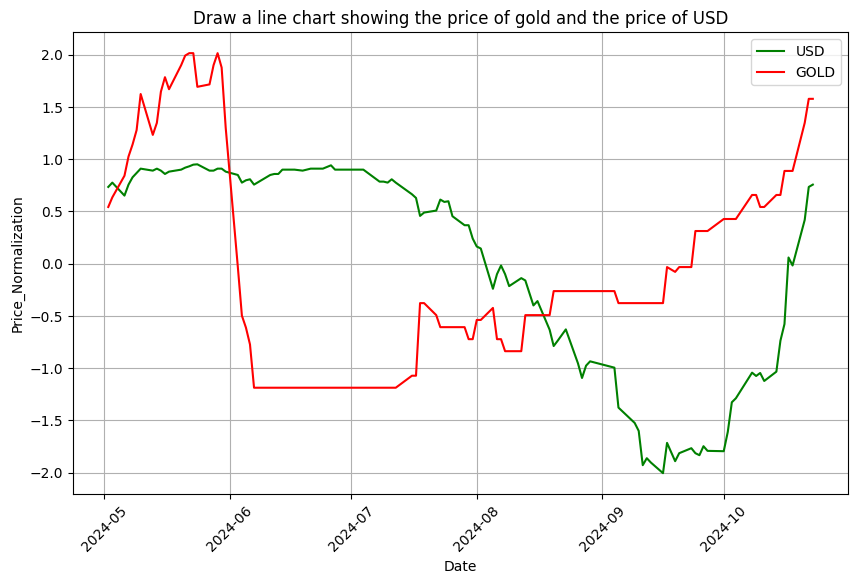

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

plt.plot(dfs.Date, dfs.USD_Price_Scaled, label='USD', linestyle='-', color='green')
plt.plot(dfs.Date, dfs.Gold_Price_Scaled, label='GOLD', linestyle='-', color='red')

plt.xlabel('Date')
plt.ylabel('Price_Normalization')
plt.title('Draw a line chart showing the price of gold and the price of USD')

plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show